In [1]:
import torch
import torch.nn as nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm

from models import BERTClass
from utils import create_modified_dataset


C:\Users\18494\.conda\envs\issue_bert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#在原始项目中，
#参数管理是通过 argparse （config.py）实现的，它可以动态解析命令行输入，并结合配置文件，使得实验的灵活性和可重复性非常高，
#尤其适用于大规模实验、云端部署或多人协作的研究环境。不过这种方式在小规模复现任务中显得较为冗余，尤其是在 Notebook 中运行时并不方便。
#因此，我们使用了一个简化版本的 Args 类，将所有超参数直接硬编码在类中，减少外部依赖，提高运行速度，也更直观易懂。
class Args:
    # Point de contrôle du modèle pré-entraîné, utilisé pour charger le modèle RoBERTa de HuggingFace
    # 预训练模型检查点，用于加载 HuggingFace 的 RoBERTa 模型
    EMB_MODEL_CHECKPOINT = "roberta-base"
    # Nom abrégé du modèle, utilisé dans les noms de fichiers
    # 模型名称标识
    EMB_MODEL_CHECKPOINT_NAME = "roberta"
    # Mappage des étiquettes : bug, enhancement, question vers des entiers
    # 标签映射，将三类标签（bug、enhancement、question）映射为数字
    LABEL_MAP = {'bug': 0, 'enhancement': 1, 'question': 2}
    DATASET_DIR = "D:/学习资料/"
    # Longueur maximale du texte d’entrée, utilisée pour le padding/troncation
    # 输入文本最大长度，用于截断和填充文本
    ISSUE_TEXT_MAX_LEN = 512
    # Seuil pour déterminer un "early issue" basé sur le numéro d'issue
     # 判断是否为“早期问题”的阈值，issue number 小于该值时标记为早期问题
    EARLY_ISSUE_THRESHOLD = 100
    # Suffixe de nom pour identifier une version particulière du dataset
    # 数据集后缀，用于加载特定预处理版本的文件
    DATASET_SUFFIX = "_dropfeature"
    
    # 补充这几个是为了训练阶段用
    
    # Taux de dropout utilisé pour éviter l’overfitting
    # dropout 概率，用于防止过拟合
    dropout = 0.24
    # Appareil utilisé pour l’entraînement, GPU si disponible
    # 训练使用的设备 使用 GPU
    device = "cuda" if torch.cuda.is_available() else "cpu"
    BATCH_SIZE = 8
    # Nombre d’époques d'entraînement
    # 训练轮数
    EPOCHS = 4
    # Taux d’apprentissage (learning rate)
    # 学习率，控制参数更新的步长
    LEARNING_RATE = 1e-5
# Instanciation de la classe des paramètres
# 实例化参数类
args = Args()

In [4]:
#对原始 CSV 数据（如 train.split.csv 和 val.split.csv）进行清洗、特征工程与编码，并生成模型可用的训练和验证数据文件
create_modified_dataset(args, dtype=['train', 'val'])


[INFO] train dataset not found. Creating...


C:\Users\18494\.conda\envs\issue_bert\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\18494\Issue-Classifier\src\utils.py:199: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  modified_df["issue_body"].replace(np.nan, '', inplace=True)


head of modified_df for debugging: 
0    implement slot exchange [B] TactJam can store ...
1    New ESMF Logging Errors in MAPL [B] My nightly...
2    First Post in a thread creates makes 'NoneType...
3    The entire body of a function should be indent...
4    Disallow sale negative stock [B] ### Backgroun...
Name: issue_text, dtype: object
[INFO] train dataset created.
[INFO] val dataset not found. Creating...


C:\Users\18494\.conda\envs\issue_bert\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
C:\Users\18494\Issue-Classifier\src\utils.py:199: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  modified_df["issue_body"].replace(np.nan, '', inplace=True)


head of modified_df for debugging: 
0    Multi-GPU training is lower than single GPU tr...
1    Update Demo Map to latest FFA map [B] Its stil...
2    Are you pulling our leg about the delete note ...
3    Round Robin Sample Playback [B] I would like t...
4    Share list from ShareThis does not work [B] Ma...
Name: issue_text, dtype: object
[INFO] val dataset created.


In [3]:
#定义了一个自定义的数据集类，用于配合 PyTorch 的 DataLoader 加载模型训练和验证所需的数据。
class CustomTextDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        import ast
        self.df = df
        # 将字符串形式的字典转换为实际字典对象
        self.df["encodings"] = self.df["encodings"].apply(ast.literal_eval)
        self.df["features"] = self.df["features"].apply(ast.literal_eval)
        
    # Retourne l'échantillon à l'indice idx
    # 返回第 idx 个样本
    def __getitem__(self, idx):
        
        row = self.df.iloc[idx]
        # Convertit les encodages texte en tenseurs PyTorch
        # 将文本编码字段转为 tensor，包括 input_ids 和 attention_mask
        encodings = {key: torch.tensor(val) for key, val in row["encodings"].items()}
        #Convertit les caractéristiques en tenseur Convertit également l'étiquette
        # 将辅助特征和标签也转换为 tensor
        features = torch.tensor(row["features"], dtype=torch.long)
        label = torch.tensor(row["label"], dtype=torch.long)
        #Retourne un dictionnaire contenant les entrées du modèle
        # 返回一个包含所有输入的字典
        return {
            "input_ids": encodings["input_ids"],
            "attention_mask": encodings["attention_mask"],
            "features": features,
            "label": label
        }
    # Retourne la taille du jeu de données
    # 返回样本总数
    def __len__(self):
        return len(self.df)

In [4]:
# Chargement du modèle RoBERTa et transfert vers GPU ou CPU
# 加载 RoBERTa 模型并移动到 GPU 或 CPU 上
from models import BERTClass
model = BERTClass(args).to(args.device)

C:\Users\18494\.conda\envs\issue_bert\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model)

In [19]:

# En raison de contraintes de calcul, nous échantillonnons 1% des données d'entraînement et 10% des données de validation
# 由于算力限制，我们只采样 1% 的训练集 和 10% 的验证集以加快训练速度
train_df = pd.read_csv(args.DATASET_DIR + "roberta_train_dropfeature.split.csv").sample(frac=0.01, random_state=42)  # 采样10%
val_df = pd.read_csv(args.DATASET_DIR + "roberta_val_dropfeature.split.csv").sample(frac=0.1, random_state=42)  #
# Préparation des ensembles de données personnalisés avec encodages et caractéristiques prétraités
# 使用自定义数据集类加载预处理好的 encodings 和特征列
train_dataset = CustomTextDataset(train_df)
val_dataset = CustomTextDataset(val_df)
# Création des DataLoaders PyTorch pour l'entraînement et la validation
# 使用 PyTorch 的 DataLoader 进行小批量训练和验证数据加载
train_loader = DataLoader(train_dataset, batch_size=args.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=args.BATCH_SIZE)

In [6]:
# Initialisation de l'optimiseur Adam avec le taux d'apprentissage défini
# 初始化优化器 Adam，使用给定的学习率
optimizer = torch.optim.Adam(model.parameters(), lr=args.LEARNING_RATE)
# Fonction de perte : Entropie croisée pour classification multi-classes
# 损失函数：多分类交叉熵损失，用于三分类问题
criterion = nn.CrossEntropyLoss()

In [7]:
# Boucle principale d'entraînement sur plusieurs époques
# 主训练循环，按照设置的轮数执行
for epoch in range(args.EPOCHS):
    # Mise en mode entraînement (active le dropout et la normalisation)
    # 将模型切换为训练模式（启用 dropout、batchnorm 等）
    model.train()
    # Initialisation de la perte cumulée pour cette époque
    # 初始化本轮总损失值
    total_loss = 0

    # Parcours de chaque batch du DataLoader d'entraînement avec barre de progression
    # 遍历每一个训练集的 batch，同时展示进度条
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        # Parcours de chaque batch du DataLoader d'entraînement avec barre de progression
        # 遍历每一个训练集的 batch，同时展示进度条
        ids = batch["input_ids"].to(args.device)
        # Masque d'attention
        # attention mask，用于标记 padding
        mask = batch["attention_mask"].to(args.device)
        # Caractéristiques supplémentaires (early issue, owner, question)
        # 三个额外的二值特征（是否早期，是否 owner，是否 question）
        features = batch["features"].to(args.device)
        # Étiquettes de vérité terrain
        # 真实标签，0-2之间的整数
        labels = batch["label"].to(args.device)

        # Prédiction du modèle
        # 模型预测输出（未经过 softmax 的 logits）
        outputs = model(ids, mask, features)
        # Calcul de la perte (CrossEntropyLoss)
        # 计算当前 batch 的损失
        loss = criterion(outputs, labels)

        # Remise à zéro des gradients
        # 清除之前积累的梯度
        optimizer.zero_grad()
        # Rétropropagation de l'erreur
        # 反向传播计算梯度
        loss.backward()
        # Mise à jour des paramètres
        # 根据梯度更新模型参数
        optimizer.step()

        # Accumulation de la perte pour cette époque
        # 累加当前 batch 的损失值
        total_loss += loss.item()
    # Affichage de la perte totale à la fin de l'époque
    # 打印当前轮次的总损失
    print(f"\nEpoch {epoch+1} - Training Loss: {total_loss:.4f}")

Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 903/903 [06:39<00:00,  2.26it/s]



Epoch 1 - Training Loss: 517.0764


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 903/903 [06:53<00:00,  2.18it/s]



Epoch 2 - Training Loss: 387.6212


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 903/903 [06:35<00:00,  2.28it/s]



Epoch 3 - Training Loss: 330.4884


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 903/903 [06:36<00:00,  2.28it/s]


Epoch 4 - Training Loss: 261.9544


In [26]:
# Passage du modèle en mode évaluation (désactive dropout, batchnorm, etc.)
# 将模型切换为评估模式（停用 dropout 和 batchnorm 等）
model.eval()

# Initialisation des listes pour stocker les prédictions et les étiquettes réelles
# 初始化用于存储预测结果和真实标签的列表
all_preds, all_labels = [], []

# Aucune mise à jour des gradients pendant l'évaluation (économie de mémoire et accélération)
# 在评估过程中不计算梯度（节省显存，加快运行速度）
with torch.no_grad():
    # Boucle sur les batchs du jeu de validation
    # 遍历验证集中的每个 batch
    for batch in val_loader:
        ids = batch["input_ids"].to(args.device)           # Identifiants des tokens d'entrée
                                                           # 输入 token 的 id 序列
        mask = batch["attention_mask"].to(args.device)     # Masque d'attention
                                                           # attention mask
        features = batch["features"].to(args.device)       # Caractéristiques supplémentaires
                                                           # 附加的二值特征
        labels = batch["label"].to(args.device)            # Étiquettes de vérité terrain
                                                           # 真实标签

        outputs = model(ids, mask, features)               # Prédictions du modèle
                                                           # 模型前向输出
        preds = torch.argmax(outputs, dim=1)               # Conversion des logits en classes
                                                           # 取最大 logit 的索引作为预测结果

        all_preds.extend(preds.cpu().numpy())              # Ajout des prédictions à la liste
                                                           # 将预测结果添加到列表
        all_labels.extend(labels.cpu().numpy())            # Ajout des étiquettes à la liste
                                                           # 将真实标签添加到列表

# Calcul du score F1 macro pour mesurer la performance globale
# 计算 macro 平均的 F1 分数作为整体性能指标
f1 = f1_score(all_labels, all_preds, average="macro")

# Affichage du score F1 pour cette époque
# 打印当前轮次的 F1 分数
print(f"Epoch {epoch+1} - Validation F1: {f1:.4f}")

# Affichage du rapport de classification complet (précision, rappel, F1 par classe)
# 打印完整的分类报告（每个类别的 precision、recall 和 F1）
print(classification_report(all_labels, all_preds, digits=4))


#'bug': 0, 'enhancement': 1, 'question': 2

Epoch 4 - Validation F1: 0.7851
              precision    recall  f1-score   support

           0     0.8889    0.8136    0.8496        59
           1     0.7179    0.9032    0.8000        31
           2     0.8571    0.6000    0.7059        10

    accuracy                         0.8200       100
   macro avg     0.8213    0.7723    0.7851       100
weighted avg     0.8327    0.8200    0.8198       100



Extracting features: 100%|█████████████████████████████████████████████████████████████| 13/13 [00:02<00:00,  5.49it/s]
C:\Users\18494\.conda\envs\issue_bert\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


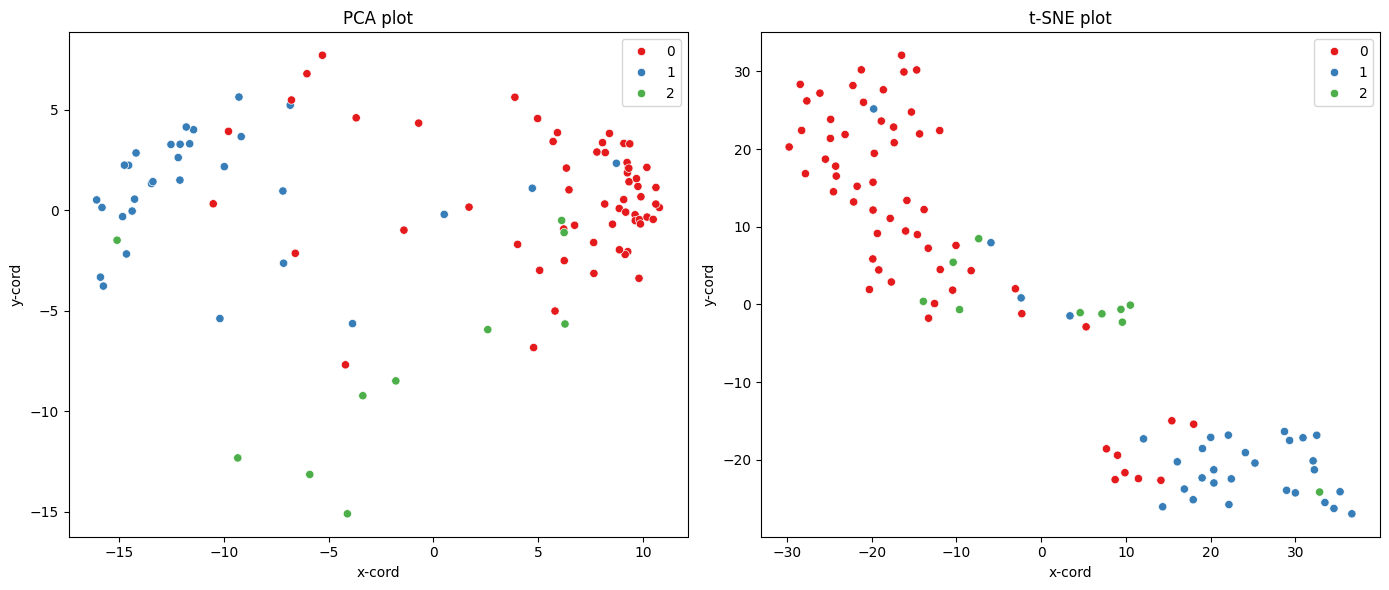

In [27]:
# Importation des modules nécessaires pour la réduction de dimensionnalité et la visualisation
# 导入用于降维和可视化的必要模块
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from tqdm import tqdm

# Passage du modèle en mode évaluation
# 设置模型为评估模式（停用 Dropout 等）
model.eval()

# Initialisation des listes pour stocker les représentations et les étiquettes
# 初始化两个列表：一个保存嵌入表示，一个保存标签
all_embeddings = []
all_labels = []

# Pas de calcul de gradient nécessaire
# 不需要计算梯度，加快运行速度，节省内存
with torch.no_grad():
    # Boucle sur les données de validation pour extraire les embeddings [CLS]
    # 遍历验证集，从每个样本中提取 [CLS] token 表示
    for batch in tqdm(val_loader, desc="Extracting features"):
        ids = batch["input_ids"].to(args.device)              # Identifiants des tokens
                                                             # 输入 token 的索引
        mask = batch["attention_mask"].to(args.device)        # Masque d’attention
                                                             # attention mask
        features = batch["features"].to(args.device)          # Caractéristiques supplémentaires
                                                             # 附加特征
        labels = batch["label"].to(args.device)               # Étiquette réelle
                                                             # 标签

        # Extraire la représentation du token [CLS] de la dernière couche cachée
        # 获取 BERT 输出的最后一层中第一个 token（即 [CLS]）的嵌入向量
        out = model.l1(ids, attention_mask=mask)[0][:, 0, :]  # [CLS] embedding

        # Ajout des embeddings et labels à la liste
        # 保存嵌入和标签
        all_embeddings.append(out.cpu())
        all_labels.extend(labels.cpu().numpy())

# Concaténation de tous les embeddings pour en faire une matrice (N x D)
# 将所有嵌入拼接成一个完整的矩阵 (样本数 × 特征维度)
X = torch.cat(all_embeddings, dim=0).numpy()
y = np.array(all_labels)

# Réduction de dimension par PCA (2 composantes principales)
# 使用 PCA 将维度降至二维（用于可视化）
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Réduction de dimension par t-SNE pour une structure plus non linéaire
# 使用 t-SNE 进行非线性降维，更好展现分布结构
tsne = TSNE(n_components=2, perplexity=7, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X)

# Création d'une figure avec deux sous-plots : PCA et t-SNE
# 创建图像并绘制两个子图（PCA 和 t-SNE）
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Visualisation des résultats PCA
# 使用 Seaborn 绘制 PCA 可视化结果
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="Set1", ax=axs[0])
axs[0].set_title("PCA plot")                 # Titre du plot
axs[0].set_xlabel("x-cord")                  # Axe X
axs[0].set_ylabel("y-cord")                  # Axe Y

# Visualisation des résultats t-SNE
# 使用 Seaborn 绘制 t-SNE 可视化结果
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="Set1", ax=axs[1])
axs[1].set_title("t-SNE plot")               # Titre du plot
axs[1].set_xlabel("x-cord")                  # Axe X
axs[1].set_ylabel("y-cord")                  # Axe Y

# Ajustement de l'espacement entre les subplots
# 自动调整子图之间间距
plt.tight_layout()

# Affichage de la figure
# 显示图像
plt.show()



In [13]:
!pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
